# Exploratory Data Analysis

#### This file contains the Exploratory Data Analysis of the Food.com dataset that I plan to use in my diet recommendation app

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import html
import re

In [ ]:
df = pd.read_csv('/Users/ignacyruszkowski/Desktop/programowanie/python/Diet/diet-recommendation-app/data/recipes.csv')

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [5]:
# Basic dataset information
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nMissing values percentage:")
print((df.isnull().sum() / len(df)) * 100)

# Descriptive statistics
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

# Unique values in categorical columns
print("\nUnique values in key categorical columns:")
print("Recipe Categories:", df['RecipeCategory'].nunique())
print("Authors:", df['AuthorId'].nunique())

# Value counts for important categorical columns
print("\nTop 10 Recipe Categories:")
print(df['RecipeCategory'].value_counts().head(10))

# Nutritional content analysis
nutrition_cols = ['Calories', 'FatContent', 'ProteinContent', 'CarbohydrateContent', 'SodiumContent']
print("\nNutritional content ranges:")
for col in nutrition_cols:
    print(f"{col}: Min={df[col].min():.1f}, Max={df[col].max():.1f}, Mean={df[col].mean():.1f}")

# Check for outliers in key numerical columns
print("\nPotential outliers (values > 99th percentile):")
for col in nutrition_cols:
    p99 = df[col].quantile(0.99)
    outliers = (df[col] > p99).sum()
    print(f"{col}: {outliers} recipes above 99th percentile ({p99:.1f})")

# Rating analysis
print("\nRating distribution:")
print(df['AggregatedRating'].value_counts().sort_index())

Dataset shape: (522517, 28)

Data types:
RecipeId                        int64
Name                           object
AuthorId                        int64
AuthorName                     object
CookTime                       object
PrepTime                       object
TotalTime                      object
DatePublished                  object
Description                    object
Images                         object
RecipeCategory                 object
Keywords                       object
RecipeIngredientQuantities     object
RecipeIngredientParts          object
AggregatedRating              float64
ReviewCount                   float64
Calories                      float64
FatContent                    float64
SaturatedFatContent           float64
CholesterolContent            float64
SodiumContent                 float64
CarbohydrateContent           float64
FiberContent                  float64
SugarContent                  float64
ProteinContent                float64
RecipeSer

In [6]:
# Count NA entries for all columns
print("Missing values (NA) count for all columns:")
print("-" * 50)
na_counts = df.isnull().sum()
for column, count in na_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{column}: {count} ({percentage:.2f}%)")

print(f"\nTotal columns: {len(df.columns)}")
print(f"Columns with missing values: {(na_counts > 0).sum()}")
print(f"Columns with no missing values: {(na_counts == 0).sum()}")

Missing values (NA) count for all columns:
--------------------------------------------------
RecipeId: 0 (0.00%)
Name: 0 (0.00%)
AuthorId: 0 (0.00%)
AuthorName: 0 (0.00%)
CookTime: 82545 (15.80%)
PrepTime: 0 (0.00%)
TotalTime: 0 (0.00%)
DatePublished: 0 (0.00%)
Description: 5 (0.00%)
Images: 1 (0.00%)
RecipeCategory: 751 (0.14%)
Keywords: 17237 (3.30%)
RecipeIngredientQuantities: 3 (0.00%)
RecipeIngredientParts: 0 (0.00%)
AggregatedRating: 253223 (48.46%)
ReviewCount: 247489 (47.36%)
Calories: 0 (0.00%)
FatContent: 0 (0.00%)
SaturatedFatContent: 0 (0.00%)
CholesterolContent: 0 (0.00%)
SodiumContent: 0 (0.00%)
CarbohydrateContent: 0 (0.00%)
FiberContent: 0 (0.00%)
SugarContent: 0 (0.00%)
ProteinContent: 0 (0.00%)
RecipeServings: 182911 (35.01%)
RecipeYield: 348071 (66.61%)
RecipeInstructions: 0 (0.00%)

Total columns: 28
Columns with missing values: 10
Columns with no missing values: 18


### First plotting the results we noticed there is a big number of outliers which we remove below

There seemed to be about 1% of observations which were outliers in each numerical category, which we remove safely. It is visible in the graphs below that there were significant improvements in the visibility of the data.

In [7]:
# Count outliers in each numerical category using 99th percentile threshold
print("=== OUTLIER ANALYSIS (Values > 99th Percentile) ===")
print("-" * 60)

numerical_cols = ['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 
                 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']

outlier_summary = {}

for col in numerical_cols:
    p99 = df[col].quantile(0.99)
    outlier_count = (df[col] > p99).sum()
    outlier_percentage = (outlier_count / len(df)) * 100
    
    outlier_summary[col] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'threshold': p99
    }
    
    print(f"{col}:")
    print(f"  99th percentile threshold: {p99:.2f}")
    print(f"  Outliers: {outlier_count:,} recipes ({outlier_percentage:.2f}%)")
    print()

# Summary table
print("=== OUTLIER SUMMARY TABLE ===")
print(f"{'Category':<20} {'Outliers':<10} {'Percentage':<12} {'Threshold':<12}")
print("-" * 60)
for col, stats in outlier_summary.items():
    print(f"{col:<20} {stats['count']:<10} {stats['percentage']:<12.2f} {stats['threshold']:<12.2f}")

# Find recipes that are outliers in multiple categories
print(f"\n=== RECIPES WITH MULTIPLE OUTLIER CATEGORIES ===")
outlier_columns = []
for col in numerical_cols:
    outlier_columns.append(df[col] > df[col].quantile(0.99))

outlier_df = pd.DataFrame(outlier_columns).T
outlier_df.columns = numerical_cols
outlier_counts_per_recipe = outlier_df.sum(axis=1)

print(f"Recipes that are outliers in multiple categories:")
for i in range(1, len(numerical_cols) + 1):
    count = (outlier_counts_per_recipe == i).sum()
    if count > 0:
        print(f"  {i} categories: {count:,} recipes")

=== OUTLIER ANALYSIS (Values > 99th Percentile) ===
------------------------------------------------------------
Calories:
  99th percentile threshold: 3642.67
  Outliers: 5,226 recipes (1.00%)

FatContent:
  99th percentile threshold: 208.10
  Outliers: 5,225 recipes (1.00%)

SaturatedFatContent:
  99th percentile threshold: 84.90
  Outliers: 5,222 recipes (1.00%)

CholesterolContent:
  99th percentile threshold: 684.48
  Outliers: 5,226 recipes (1.00%)

SodiumContent:
  99th percentile threshold: 5569.08
  Outliers: 5,226 recipes (1.00%)

CarbohydrateContent:
  99th percentile threshold: 476.60
  Outliers: 5,225 recipes (1.00%)

FiberContent:
  99th percentile threshold: 27.10
  Outliers: 5,204 recipes (1.00%)

SugarContent:
  99th percentile threshold: 299.70
  Outliers: 5,222 recipes (1.00%)

ProteinContent:
  99th percentile threshold: 95.60
  Outliers: 5,225 recipes (1.00%)

=== OUTLIER SUMMARY TABLE ===
Category             Outliers   Percentage   Threshold   
------------------

In [8]:
# Remove outliers from the dataset based on 99th percentile threshold
print("=== REMOVING OUTLIERS FROM DATASET ===")
print("-" * 50)

# Create a copy of the original dataset for comparison
df_original = df.copy()
print(f"Original dataset size: {len(df_original):,} recipes")

# Identify outliers using 99th percentile threshold for each numerical column
outlier_mask = pd.Series([False] * len(df), index=df.index)

for col in numerical_cols:
    p99 = df[col].quantile(0.99)
    col_outliers = df[col] > p99
    outlier_mask = outlier_mask | col_outliers
    print(f"{col}: {col_outliers.sum():,} outliers removed (>{p99:.2f})")

# Remove outliers
df = df[~outlier_mask]

print(f"\nDataset size after removing outliers: {len(df):,} recipes")
print(f"Total outliers removed: {outlier_mask.sum():,} recipes ({(outlier_mask.sum()/len(df_original)*100):.2f}%)")
print(f"Percentage of data retained: {(len(df)/len(df_original)*100):.2f}%")

# Display new statistics for key columns
print("\n=== UPDATED DATASET STATISTICS ===")
for col in ['Calories', 'ProteinContent', 'FatContent']:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    print(f"  99th percentile: {df[col].quantile(0.99):.2f}")

=== REMOVING OUTLIERS FROM DATASET ===
--------------------------------------------------
Original dataset size: 522,517 recipes
Calories: 5,226 outliers removed (>3642.67)
FatContent: 5,225 outliers removed (>208.10)
SaturatedFatContent: 5,222 outliers removed (>84.90)
CholesterolContent: 5,226 outliers removed (>684.48)
SodiumContent: 5,226 outliers removed (>5569.08)
CarbohydrateContent: 5,225 outliers removed (>476.60)
FiberContent: 5,204 outliers removed (>27.10)
SugarContent: 5,222 outliers removed (>299.70)
ProteinContent: 5,225 outliers removed (>95.60)

Dataset size after removing outliers: 502,510 recipes
Total outliers removed: 20,007 recipes (3.83%)
Percentage of data retained: 96.17%

=== UPDATED DATASET STATISTICS ===

Calories:
  Mean: 387.84
  Median: 306.00
  Max: 3637.40
  99th percentile: 1746.60

ProteinContent:
  Mean: 15.20
  Median: 8.60
  Max: 95.60
  99th percentile: 70.30

FatContent:
  Mean: 19.50
  Median: 13.30
  Max: 208.10
  99th percentile: 109.40


/var/folders/ps/3hcpxxsj0jv9n17sj8qdpztc0000gn/T/ipykernel_32078/3844211570.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df_top_cat[df_top_cat['RecipeCategory'] == cat]['Calories'].values
/var/folders/ps/3hcpxxsj0jv9n17sj8qdpztc0000gn/T/ipykernel_32078/3844211570.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_top_cat[df_top_cat['RecipeCategory'] == cat]['ProteinContent'].values


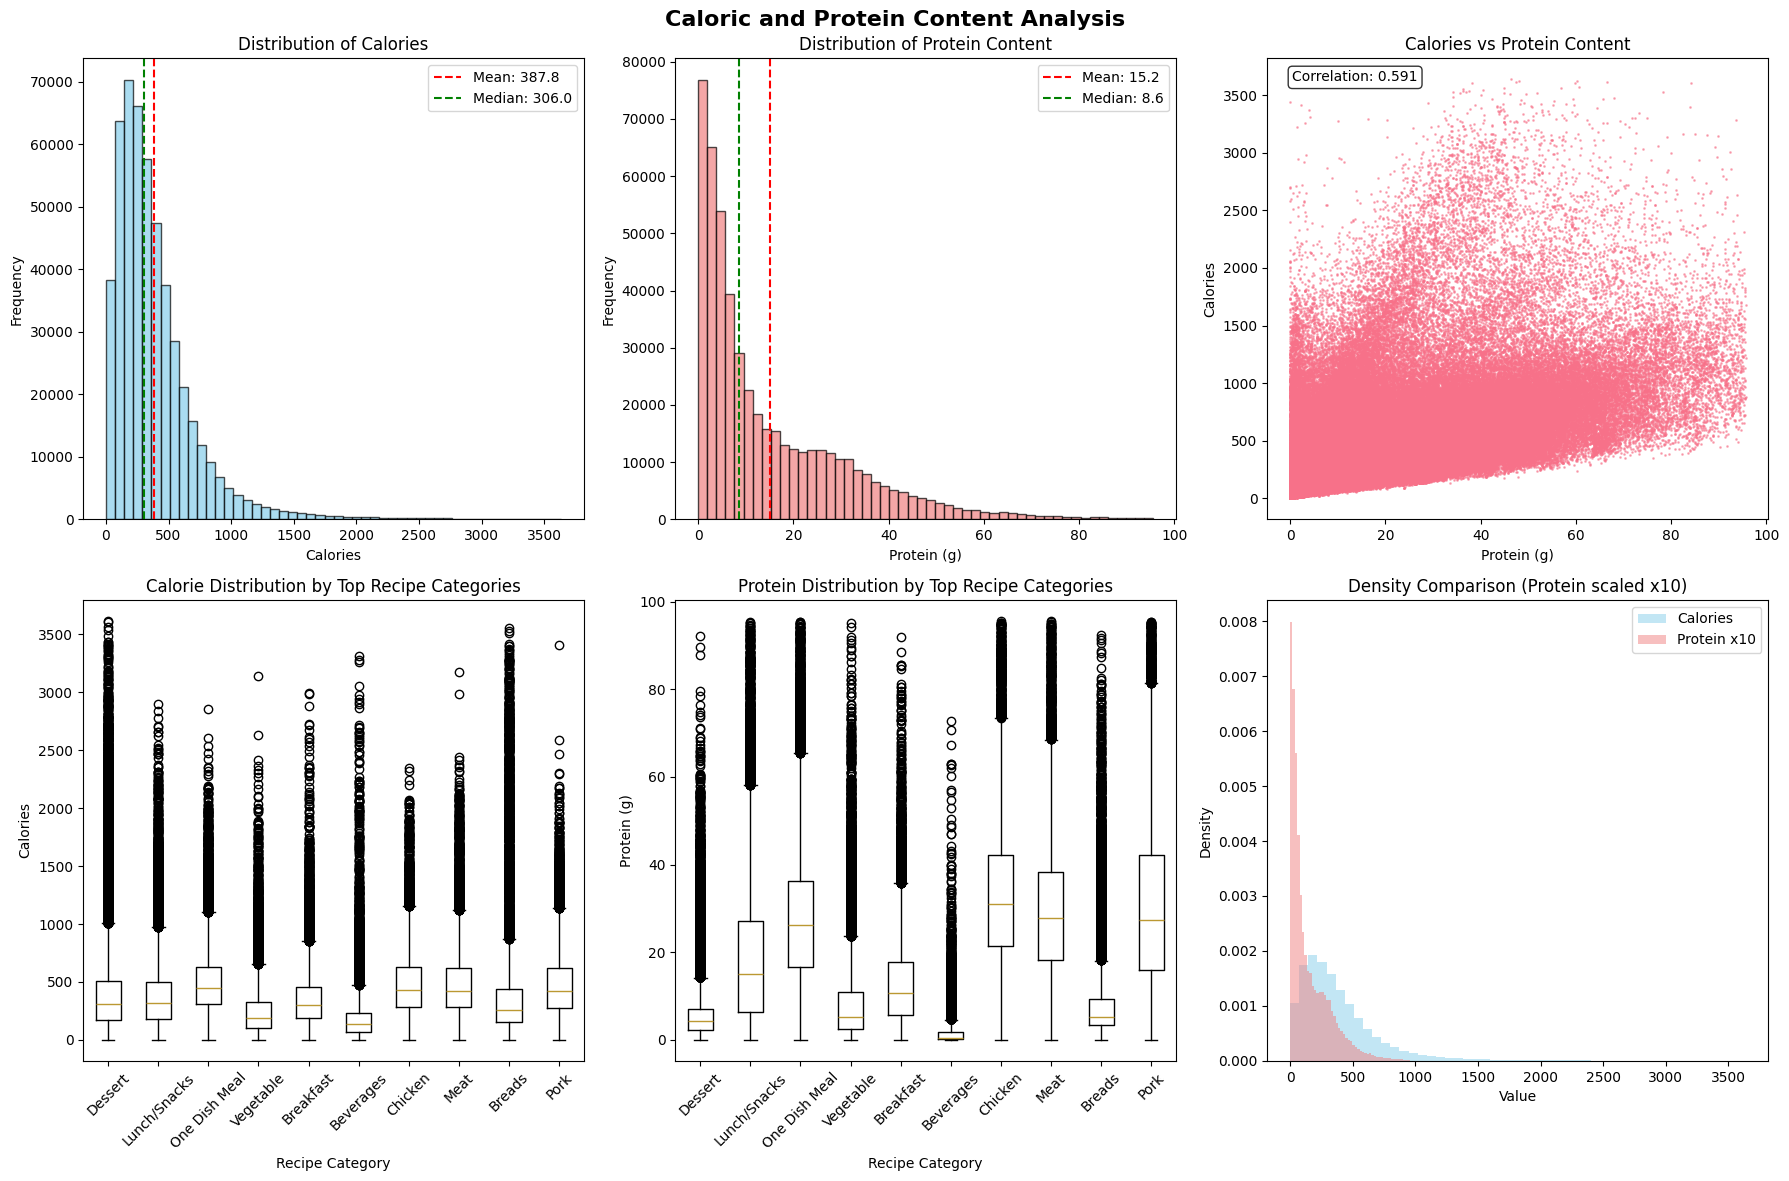

=== CALORIC CONTENT ANALYSIS ===
Mean calories: 387.84
Median calories: 306.00
Standard deviation: 338.66
Min calories: 0.00
Max calories: 3637.40
25th percentile: 169.70
75th percentile: 499.60
99th percentile: 1746.60

=== PROTEIN CONTENT ANALYSIS ===
Mean protein: 15.20g
Median protein: 8.60g
Standard deviation: 16.10g
Min protein: 0.00g
Max protein: 95.60g
25th percentile: 3.40g
75th percentile: 23.50g
99th percentile: 70.30g

=== CORRELATION ANALYSIS ===
Correlation between Calories and Protein: 0.5911

=== HIGH CALORIE RECIPES (>1000 calories) ===
Number of high-calorie recipes: 24013 (4.78%)
Average protein in high-calorie recipes: 38.46g

=== HIGH PROTEIN RECIPES (>30g protein) ===
Number of high-protein recipes: 85394 (16.99%)
Average calories in high-protein recipes: 733.79


In [9]:
# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Caloric and Protein Content Analysis', fontsize=16, fontweight='bold')

# 1. Calorie distribution histogram
axes[0, 0].hist(df['Calories'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Calories')
axes[0, 0].set_xlabel('Calories')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['Calories'].mean(), color='red', linestyle='--', label=f'Mean: {df["Calories"].mean():.1f}')
axes[0, 0].axvline(df['Calories'].median(), color='green', linestyle='--', label=f'Median: {df["Calories"].median():.1f}')
axes[0, 0].legend()

# 2. Protein distribution histogram
axes[0, 1].hist(df['ProteinContent'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Protein Content')
axes[0, 1].set_xlabel('Protein (g)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['ProteinContent'].mean(), color='red', linestyle='--', label=f'Mean: {df["ProteinContent"].mean():.1f}')
axes[0, 1].axvline(df['ProteinContent'].median(), color='green', linestyle='--', label=f'Median: {df["ProteinContent"].median():.1f}')
axes[0, 1].legend()

# 3. Scatter plot: Calories vs Protein
axes[0, 2].scatter(df['ProteinContent'], df['Calories'], alpha=0.5, s=1)
axes[0, 2].set_title('Calories vs Protein Content')
axes[0, 2].set_xlabel('Protein (g)')
axes[0, 2].set_ylabel('Calories')

# Add correlation coefficient
correlation = df['Calories'].corr(df['ProteinContent'])
axes[0, 2].text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=axes[0, 2].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Box plots for calories by recipe category (top 10 categories)
top_categories = df['RecipeCategory'].value_counts().head(10).index
df_top_cat = df[df['RecipeCategory'].isin(top_categories)]
axes[1, 0].boxplot([df_top_cat[df_top_cat['RecipeCategory'] == cat]['Calories'].values 
                    for cat in top_categories], labels=top_categories)
axes[1, 0].set_title('Calorie Distribution by Top Recipe Categories')
axes[1, 0].set_xlabel('Recipe Category')
axes[1, 0].set_ylabel('Calories')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Box plots for protein by recipe category (top 10 categories)
axes[1, 1].boxplot([df_top_cat[df_top_cat['RecipeCategory'] == cat]['ProteinContent'].values 
                    for cat in top_categories], labels=top_categories)
axes[1, 1].set_title('Protein Distribution by Top Recipe Categories')
axes[1, 1].set_xlabel('Recipe Category')
axes[1, 1].set_ylabel('Protein (g)')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Calorie and protein density plots
axes[1, 2].hist(df['Calories'], bins=50, alpha=0.5, density=True, label='Calories', color='skyblue')
axes[1, 2].hist(df['ProteinContent']*10, bins=50, alpha=0.5, density=True, label='Protein x10', color='lightcoral')
axes[1, 2].set_title('Density Comparison (Protein scaled x10)')
axes[1, 2].set_xlabel('Value')
axes[1, 2].set_ylabel('Density')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("=== CALORIC CONTENT ANALYSIS ===")
print(f"Mean calories: {df['Calories'].mean():.2f}")
print(f"Median calories: {df['Calories'].median():.2f}")
print(f"Standard deviation: {df['Calories'].std():.2f}")
print(f"Min calories: {df['Calories'].min():.2f}")
print(f"Max calories: {df['Calories'].max():.2f}")
print(f"25th percentile: {df['Calories'].quantile(0.25):.2f}")
print(f"75th percentile: {df['Calories'].quantile(0.75):.2f}")
print(f"99th percentile: {df['Calories'].quantile(0.99):.2f}")

print("\n=== PROTEIN CONTENT ANALYSIS ===")
print(f"Mean protein: {df['ProteinContent'].mean():.2f}g")
print(f"Median protein: {df['ProteinContent'].median():.2f}g")
print(f"Standard deviation: {df['ProteinContent'].std():.2f}g")
print(f"Min protein: {df['ProteinContent'].min():.2f}g")
print(f"Max protein: {df['ProteinContent'].max():.2f}g")
print(f"25th percentile: {df['ProteinContent'].quantile(0.25):.2f}g")
print(f"75th percentile: {df['ProteinContent'].quantile(0.75):.2f}g")
print(f"99th percentile: {df['ProteinContent'].quantile(0.99):.2f}g")

print("\n=== CORRELATION ANALYSIS ===")
print(f"Correlation between Calories and Protein: {df['Calories'].corr(df['ProteinContent']):.4f}")

print("\n=== HIGH CALORIE RECIPES (>1000 calories) ===")
high_cal = df[df['Calories'] > 1000]
print(f"Number of high-calorie recipes: {len(high_cal)} ({len(high_cal)/len(df)*100:.2f}%)")
print(f"Average protein in high-calorie recipes: {high_cal['ProteinContent'].mean():.2f}g")

print("\n=== HIGH PROTEIN RECIPES (>30g protein) ===")
high_protein = df[df['ProteinContent'] > 30]
print(f"Number of high-protein recipes: {len(high_protein)} ({len(high_protein)/len(df)*100:.2f}%)")
print(f"Average calories in high-protein recipes: {high_protein['Calories'].mean():.2f}")

In [10]:
pd.set_option('display.max_columns', None) # Show all columns in the df, to see the name of the keywords category
df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,RecipeIngredientParts,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")","c(""blueberries"", ""granulated sugar"", ""vanilla ...",4.5,4.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""saffron"", ""milk"", ""hot green chili peppers""...",3.0,1.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...",4.5,10.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...",4.5,2.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")","c(""plain tomato juice"", ""cabbage"", ""onion"", ""c...",4.5,11.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [11]:
# Count the unique values in keywords
print(df['Keywords'].nunique())
df['Keywords'].value_counts().head(20)

209566


Keywords
"Easy"                                                                 11919
c("< 15 Mins", "Easy")                                                  9516
"< 60 Mins"                                                             9391
"< 4 Hours"                                                             6627
"< 30 Mins"                                                             6032
c("< 30 Mins", "Easy")                                                  5548
c("< 60 Mins", "Easy")                                                  4860
c("< 4 Hours", "Easy")                                                  3065
"< 15 Mins"                                                             2637
c("Low Protein", "Low Cholesterol", "Healthy", "< 15 Mins", "Easy")     1405
c("Meat", "< 60 Mins")                                                  1354
c("Meat", "< 4 Hours")                                                  1319
c("Vegetable", "< 60 Mins")                                        

In [12]:
from collections import Counter

# Extract all unique keywords from the dataset
all_keywords = []

# Process each recipe's keywords
for keywords_str in df['Keywords'].dropna():
    if keywords_str.startswith('c('):
        # Remove 'c(' prefix and ')' suffix
        keywords_clean = keywords_str[2:-1]
        
        # Split by '", "' and clean each keyword
        keywords_list = keywords_clean.split('", "')
        
        # Remove quotes from first and last items
        if keywords_list:
            keywords_list[0] = keywords_list[0].lstrip('"')
            keywords_list[-1] = keywords_list[-1].rstrip('"')
        
        all_keywords.extend(keywords_list)

# Get unique keywords and sort them
unique_keywords = sorted(set(all_keywords))

# Display results
print(f"Total unique keywords: {len(unique_keywords)}")
print(f"\nFirst 20 keywords:")
for i, keyword in enumerate(unique_keywords[:20], 1):
    print(f"{i}. {keyword}")

print(f"\nLast 20 keywords:")
for i, keyword in enumerate(unique_keywords[-20:], len(unique_keywords)-19):
    print(f"{i}. {keyword}")

# Show most common keywords
keyword_counts = Counter(all_keywords)
print(f"\nTop 20 most common keywords:")
for keyword, count in keyword_counts.most_common(20):
    print(f"{keyword}: {count}")


Total unique keywords: 311

First 20 keywords:
1. < 15 Mins
2. < 30 Mins
3. < 4 Hours
4. < 60 Mins
5. African
6. Apple
7. Artichoke
8. Asian
9. Australian
10. Austrian
11. Avocado
12. Baked Beans
13. Baking
14. Bar Cookie
15. Bass
16. Bath/Beauty
17. Bean Soup
18. Beans
19. Bear
20. Beef Crock Pot

Last 20 keywords:
292. Tuna
293. Turkey Breasts
294. Turkish
295. Veal
296. Vegan
297. Vegetable
298. Venezuelan
299. Very Low Carbs
300. Vietnamese
301. Weeknight
302. Welsh
303. White Rice
304. Whitefish
305. Whole Chicken
306. Whole Duck
307. Whole Turkey
308. Wild Game
309. Winter
310. Yam/Sweet Potato
311. Yeast Breads

Top 20 most common keywords:
Easy: 255607
< 60 Mins: 135614
< 30 Mins: 103512
Meat: 98925
< 4 Hours: 98205
< 15 Mins: 83366
Healthy: 79999
Vegetable: 79523
Low Cholesterol: 71624
Beginner Cook: 65249
Inexpensive: 63936
Low Protein: 61389
Fruit: 57798
Oven: 51479
Kid Friendly: 49724
European: 45297
Poultry: 44715
Weeknight: 42429
Dessert: 40686
For Large Groups: 40482


We see that there are 311 unique keywords, this will be helpful to manage the dietary preferences later on

In [13]:
# Count frequency of each keyword in the Keywords column
keyword_frequency = {}

# Process each recipe's keywords
for keywords_str in df['Keywords'].dropna():
    if keywords_str.startswith('c('):
        # Remove 'c(' prefix and ')' suffix
        keywords_clean = keywords_str[2:-1]
        
        # Split by '", "' and clean each keyword
        keywords_list = keywords_clean.split('", "')
        
        # Remove quotes from all items properly
        keywords_list = [keyword.strip().strip('"') for keyword in keywords_list]
        
        # Count each keyword (only non-empty ones)
        for keyword in keywords_list:
            if keyword:  # Only add non-empty keywords
                keyword_frequency[keyword] = keyword_frequency.get(keyword, 0) + 1

# Convert to sorted list of tuples for better visualization
keyword_freq_sorted = sorted(keyword_frequency.items(), key=lambda x: x[1], reverse=True)

print(f"=== KEYWORD FREQUENCY ANALYSIS ===")
print(f"Total unique keywords found: {len(keyword_frequency)}")
print(f"Total recipes with keywords: {df['Keywords'].notna().sum()}")
print(f"\nTop 30 most frequent keywords:")
print("-" * 50)

for i, (keyword, freq) in enumerate(keyword_freq_sorted[:30], 1):
    percentage = (freq / len(df)) * 100
    print(f"{i:2d}. {keyword:<25} {freq:>6,} ({percentage:5.2f}%)")

print(f"\nBottom 20 least frequent keywords:")
print("-" * 50)

for i, (keyword, freq) in enumerate(keyword_freq_sorted[-20:], len(keyword_freq_sorted)-19):
    percentage = (freq / len(df)) * 100
    print(f"{i:2d}. {keyword:<25} {freq:>6,} ({percentage:5.2f}%)")

# Summary statistics
frequencies = list(keyword_frequency.values())
print(f"\n=== KEYWORD FREQUENCY STATISTICS ===")
print(f"Mean frequency: {sum(frequencies)/len(frequencies):.2f}")
print(f"Median frequency: {sorted(frequencies)[len(frequencies)//2]:.2f}")
print(f"Most frequent keyword: '{keyword_freq_sorted[0][0]}' ({keyword_freq_sorted[0][1]:,} times)")
print(f"Least frequent keywords: {sum(1 for freq in frequencies if freq == 1)} keywords appear only once")


=== KEYWORD FREQUENCY ANALYSIS ===
Total unique keywords found: 311
Total recipes with keywords: 485947

Top 30 most frequent keywords:
--------------------------------------------------
 1. Easy                      255,607 (50.87%)
 2. < 60 Mins                 135,614 (26.99%)
 3. < 30 Mins                 103,512 (20.60%)
 4. Meat                      98,925 (19.69%)
 5. < 4 Hours                 98,205 (19.54%)
 6. < 15 Mins                 83,366 (16.59%)
 7. Healthy                   79,999 (15.92%)
 8. Vegetable                 79,523 (15.83%)
 9. Low Cholesterol           71,624 (14.25%)
10. Beginner Cook             65,249 (12.98%)
11. Inexpensive               63,936 (12.72%)
12. Low Protein               61,389 (12.22%)
13. Fruit                     57,798 (11.50%)
14. Oven                      51,479 (10.24%)
15. Kid Friendly              49,724 ( 9.90%)
16. European                  45,297 ( 9.01%)
17. Poultry                   44,715 ( 8.90%)
18. Weeknight               

Clearly some of the keywords overlap. By using logic every meal which is < 15 minutes should also be < 4 Hours but this is not always encoded. That should not be too big of a problem.

In [14]:
# Count frequency of each ingredient in the RecipeIngredientParts column
ingredient_frequency = {}

# Process each recipe's ingredients
for ingredients_str in df['RecipeIngredientParts'].dropna():
    if ingredients_str.startswith('c('):
        # Remove 'c(' prefix and ')' suffix
        ingredients_clean = ingredients_str[2:-1]
        
        # Split by '", "' and clean each ingredient
        ingredients_list = ingredients_clean.split('", "')
        
        # Remove quotes from first and last items properly
        if ingredients_list:
            # Remove leading quote from first item
            ingredients_list[0] = ingredients_list[0].lstrip('"')
            # Remove trailing quote from last item
            ingredients_list[-1] = ingredients_list[-1].rstrip('"')
        
        # Count each ingredient (convert to lowercase to avoid overlap)
        for ingredient in ingredients_list:
            # Clean any remaining quotes and whitespace
            ingredient_clean = ingredient.strip().strip('"').lower()
            if ingredient_clean:  # Only add non-empty ingredients
                ingredient_frequency[ingredient_clean] = ingredient_frequency.get(ingredient_clean, 0) + 1

# Convert to sorted list of tuples for better visualization
ingredient_freq_sorted = sorted(ingredient_frequency.items(), key=lambda x: x[1], reverse=True)

print(f"=== INGREDIENT FREQUENCY ANALYSIS ===")
print(f"Total unique ingredients found: {len(ingredient_frequency)}")
print(f"Total recipes with ingredients: {df['RecipeIngredientParts'].notna().sum()}")
print(f"\nTop 30 most frequent ingredients:")
print("-" * 50)

for i, (ingredient, freq) in enumerate(ingredient_freq_sorted[:30], 1):
    percentage = (freq / len(df)) * 100
    print(f"{i:2d}. {ingredient:<25} {freq:>6,} ({percentage:5.2f}%)")

print(f"\nBottom 20 least frequent ingredients:")
print("-" * 50)

for i, (ingredient, freq) in enumerate(ingredient_freq_sorted[-20:], len(ingredient_freq_sorted)-19):
    percentage = (freq / len(df)) * 100
    print(f"{i:2d}. {ingredient:<25} {freq:>6,} ({percentage:5.2f}%)")

# Summary statistics
frequencies = list(ingredient_frequency.values())
print(f"\n=== INGREDIENT FREQUENCY STATISTICS ===")
print(f"Mean frequency: {sum(frequencies)/len(frequencies):.2f}")
print(f"Median frequency: {sorted(frequencies)[len(frequencies)//2]:.2f}")
print(f"Most frequent ingredient: '{ingredient_freq_sorted[0][0]}' ({ingredient_freq_sorted[0][1]:,} times)")
print(f"Least frequent ingredients: {sum(1 for freq in frequencies if freq == 1)} ingredients appear only once")

=== INGREDIENT FREQUENCY ANALYSIS ===
Total unique ingredients found: 7248
Total recipes with ingredients: 502510

Top 30 most frequent ingredients:
--------------------------------------------------
 1. salt                      190,989 (38.01%)
 2. butter                    129,551 (25.78%)
 3. sugar                     108,741 (21.64%)
 4. onion                     85,425 (17.00%)
 5. water                     79,564 (15.83%)
 6. eggs                      76,290 (15.18%)
 7. olive oil                 74,740 (14.87%)
 8. flour                     59,121 (11.77%)
 9. milk                      58,592 (11.66%)
10. garlic cloves             57,740 (11.49%)
11. pepper                    48,558 ( 9.66%)
12. all-purpose flour         41,718 ( 8.30%)
13. brown sugar               40,292 ( 8.02%)
14. egg                       38,510 ( 7.66%)
15. baking powder             37,546 ( 7.47%)
16. garlic                    34,263 ( 6.82%)
17. parmesan cheese           32,053 ( 6.38%)
18. lemon juice

In [25]:
def clean_ingredient_text(text):
    """
    A more robust function to clean ingredient text.
    - Unescapes HTML entities (e.g., '&quot;' becomes '"').
    - Removes quotes.
    - Converts to lowercase.
    - Replaces multiple spaces with a single space.
    - Strips leading/trailing whitespace.
    """
    # 1. Unescape HTML entities
    text = html.unescape(text)
    
    # 2. Remove quotation marks
    text = text.replace('"', '')
    
    # 3. Convert to lowercase
    text = text.lower()
    
    # 4. Replace multiple whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # 5. Remove any leading/trailing whitespace that might be left
    text = text.strip()
    
    return text

# Use a set to automatically store only unique ingredients
unique_ingredients = set()

# Process each recipe's ingredients
for ingredients_str in df['RecipeIngredientParts'].dropna():
    if isinstance(ingredients_str, str) and ingredients_str.startswith('c('):
        # Remove 'c(' prefix and ')' suffix
        ingredients_clean_str = ingredients_str[2:-1]
        
        # Split by '", "' which is a common delimiter in this format
        ingredients_list = ingredients_clean_str.split('", "')
        
        # Add each cleaned ingredient to the set using the new function
        for ingredient in ingredients_list:
            # Use the new, more powerful cleaning function here
            ingredient_clean = clean_ingredient_text(ingredient)
            if ingredient_clean:
                unique_ingredients.add(ingredient_clean)

# Convert the final set to a sorted list for clean output
sorted_unique_ingredients = sorted(list(unique_ingredients))

# --- Output the Results ---
print(f"=== CLEANED UNIQUE INGREDIENTS FOUND ===")
print(f"Total unique ingredients: {len(sorted_unique_ingredients)}")
print("-" * 50)
# Print the first 50 cleaned ingredients as a sample
print(sorted_unique_ingredients)

=== CLEANED UNIQUE INGREDIENTS FOUND ===
Total unique ingredients: 7362
--------------------------------------------------
['1% fat buttermilk', '1% fat cottage cheese', '1% low-fat chocolate milk', '1% low-fat milk', '1-1/2 ingredient fiber crust', '10 inch low-fat flour tortillas', '10-inch 98% fat-free flour tortilla', '10-inch corn tortillas', '10-inch flour tortilla', '10-inch flour tortillas', '10-inch sun-dried tomato tortillas', '10-inch whole wheat tortillas', '10-minute success rice', '100 proof vodka', '12-inch flour tortilla', '12-inch flour tortillas', '12-inch tortilla', '2 texans craving salsa far from home', '2% buttermilk', '2% cheddar cheese', '2% evaporated milk', '2% fat cottage cheese', '2% large-curd cottage cheese', '2% low-fat chocolate milk', '2% low-fat milk', '2% milk', '2% mozzarella cheese', '20% sour cream', "2bleu's 2 minute 2 easy pizza sauce", "2bleu's sweet mustard sauce for pretzels and more!", '3 legume butter', '3-cheese gourmet cheddar blend cheese

In [15]:
df.isnull().sum()/ len(df) * 100 # the percentage of missing values in each column

RecipeId                       0.000000
Name                           0.000000
AuthorId                       0.000000
AuthorName                     0.000000
CookTime                      15.700185
PrepTime                       0.000000
TotalTime                      0.000000
DatePublished                  0.000000
Description                    0.000796
Images                         0.000199
RecipeCategory                 0.137311
Keywords                       3.296054
RecipeIngredientQuantities     0.000597
RecipeIngredientParts          0.000000
AggregatedRating              48.340531
ReviewCount                   47.264731
Calories                       0.000000
FatContent                     0.000000
SaturatedFatContent            0.000000
CholesterolContent             0.000000
SodiumContent                  0.000000
CarbohydrateContent            0.000000
FiberContent                   0.000000
SugarContent                   0.000000
ProteinContent                 0.000000


### Encoding

There clearly is value to be gained from introducing some form of encoding. This will enable to effectively filter the desired features of a meal in the final versions of the app.

### Cleaning the Keywords and Recipe Ingredients Parts columns

In [16]:
# Define cleaning function with proper NA handling
def clean_r_list_column(series):
    return (series
            .str.strip('c()')
            .str.replace('"', '', regex=False)
            .str.split(',')
            .apply(lambda x: [item.strip() for item in x] if x is not None and isinstance(x, list) else []))

# Apply to both columns
df['Keywords'] = clean_r_list_column(df['Keywords']).apply(lambda x: [kw.lower() for kw in x])
df['RecipeIngredientParts'] = clean_r_list_column(df['RecipeIngredientParts'])

# Remove NAs and empty lists, reset index
df = df[
    (df['Keywords'].apply(len) > 0) & 
    (df['RecipeIngredientParts'].apply(len) > 0)
].reset_index(drop=True)

In [22]:
#Getting a list of all the ingredients for future encoding
unique_ingredients = df['RecipeIngredientParts'].explode().unique().tolist()
print(unique_ingredients)

['blueberries', 'granulated sugar', 'vanilla yogurt', 'lemon juice', 'saffron', 'milk', 'hot green chili peppers', 'onions', 'garlic', 'clove', 'peppercorns', 'cardamom seed', 'cumin seed', 'poppy seed', 'mace', 'cilantro', 'mint leaf', 'fresh lemon juice', 'plain yogurt', 'boneless chicken', 'salt', 'ghee', 'onion', 'tomatoes', 'basmati rice', 'long-grain rice', 'raisins', 'cashews', 'eggs', 'sugar', 'lemons', 'rind of', 'lemon', 'zest of', 'fresh water', 'extra firm tofu', 'eggplant', 'zucchini', 'mushrooms', 'soy sauce', 'low sodium soy sauce', 'olive oil', 'maple syrup', 'honey', 'red wine vinegar', 'garlic cloves', 'mustard powder', 'black pepper', 'plain tomato juice', 'cabbage', 'carrots', 'celery', 'graham cracker crumbs', 'butter', 'cornstarch', 'vanilla extract', 'water', 'gelatin', 'rum', 'cream of tartar', 'chicken', 'flour', 'button mushrooms', 'green pepper', 'canned pimiento', 'Worcestershire sauce', 'parsley', 'margarine', 'egg', 'buttermilk', 'rice vinegar', 'haeo', 'b

In [ ]:
easy_encoding = np.zeros(len(df))

for i in range(len(df)):
    if 'easy' in df['Keywords'][i]:
        easy_encoding[i] = 1
    else:
        easy_encoding[i] = 0
df['Easy'] = easy_encoding
print(sum(df['Easy']/len(df))) #Returns 0.55

0.5505250572600343


the categories I should focus on encoding now are: Dietary Restrictions (Priority 1):

Vegetarian - combine "vegetarian", "vegan" keywords ✅\
Vegan - specifically "vegan" keyword ✅ \
GlutenFree - "gluten-free", "wheat-free" keywords skip na razie ❌\
DairyFree - "dairy-free", "lactose-free" keywords skip na razie ❌\
Time Categories (Priority 2): \

QuickMeals - "< 15 mins", "< 30 mins", "weeknight" ✅ \
StandardPrep - "< 60 mins", "< 4 hours" ✅\
LongPrep - "> 4 hours", "slow cooker" ✅\
also extended the above categories to include more entries, possibly make them smaller in the future
Difficulty Level (Priority 3) for the MVP I am skipping these filters:

Easy (already done)
Beginner - "beginner", "simple" keywords
Advanced - "intermediate", "advanced" keywords


In [18]:
# meat_list = sorted(list(set([
#     "beef", "beef kidney", "beef liver", "beef organ meats", "beef sandwiches", "roast beef", "steak", "pot roast", "veal",
#     "pork", "pork loin", "ham", "bacon", "sausage", "lamb/sheep", "lamb", "sheep", "poultry", "chicken",
#     "chicken breast", "chicken livers", "chicken stews", "chicken thigh & leg", "whole chicken", "turkey",
#     "turkey breasts", "whole turkey", "duck", "duck breasts", "whole duck", "goose", "quail", "pheasant",
#     "fish", "bass", "catfish", "cod", "halibut", "mahi mahi", "orange roughy", "perch", "salmon", "tilapia",
#     "trout", "tuna", "whitefish", "shellfish",
#     "crab", "crawfish", "lobster", "mussels", "octopus", "oysters", "squid",
#     "bear", "deer", "elk", "moose", "rabbit", "wild game", "meat", "meatballs", "meatloaf"
# ])))
meat_list = sorted(list(set([
    "ahi", "albacore tuna", "all beef wieners", "alligator meat", "alligator sausage", "alligator tail steaks", "anchovies", "anchovy", "anchovy fillet", "anchovy fillets", "anchovy paste", "andouille chicken sausage", "andouille sausage", "andouille sausages", "andouille turkey sausage", "baby beef liver", "baby chickens", "baby clams", "baby shrimp", "back bacon", "bacon", "bacon bits", "bacon drippings", "bacon fat", "bacon grease", "bacon-meatloaf", "bangers", "barbecued chicken", "barbecued pork", "bay scallop", "bay scallops", "bay shrimp", "beef", "beef bones with marrow", "beef bouillon cube", "beef bouillon cubes", "beef bouillon granules", "beef bouillon powder", "beef brisket", "beef broth", "beef burger", "beef burgers", "beef chuck", "beef chuck with bone", "beef cube", "beef cubes", "beef drippings", "beef eye round", "beef fat", "beef flank steak", "beef kielbasa", "beef liver", "beef mince", "beef rib", "beef ribs", "beef roast", "beef round rump roast", "beef round steak", "beef round tip steak", "beef round tip steaks", "beef schnitzel", "beef shank", "beef short ribs with bones", "beef silverside", "beef sirloin", "beef sirloin steak", "beef sirloin steaks", "beef steak", "beef steaks", "beef stew meat", "beef suet", "beef sweetbreads", "beef tenderloin", "beef tenderloin steak", "beef tenderloin steaks", "beef tip roast", "beef top round", "beef top round steak", "biltong", "black cod steaks", "blue-eye cod fillet", "boiling shrimp", "boned lamb", "boneless atlantic salmon fillet", "boneless beef chuck", "boneless beef chuck roast", "boneless beef cube", "boneless beef cubes", "boneless beef roast", "boneless beef round steak", "boneless beef rump roast", "boneless beef sirloin", "boneless beef top loin steak", "boneless beef top loin steaks", "boneless beef top round", "boneless beef top round steak", "boneless beef top round steaks", "boneless beef top sirloin steak", "boneless beef top sirloin steaks", "boneless center cut pork chop", "boneless center cut pork chops", "boneless center cut pork loin roast", "boneless chicken", "boneless chicken breast", "boneless chicken breast half", "boneless chicken breast halve", "boneless chicken breast halves", "boneless chicken breasts", "boneless chicken cutlet", "boneless duck breast", "boneless duck breast halves", "boneless duck breasts", "boneless duck meat", "boneless fresh pork", "boneless lamb", "boneless lamb chops", "boneless lamb loin", "boneless lamb roast", "boneless lean lamb", "boneless lean pork", "boneless leg of lamb", "boneless pork", "boneless pork blade roast", "boneless pork chop", "boneless pork chops", "boneless pork cutlet", "boneless pork cutlets", "boneless pork filet", "boneless pork filets", "boneless pork leg", "boneless pork loin", "boneless pork loin chop", "boneless pork loin chops", "boneless pork loin roast", "boneless pork loin steaks", "boneless pork ribs", "boneless pork roast", "boneless pork shoulder", "boneless pork sirloin", "boneless pork top loin", "boneless round steak", "boneless salmon fillet", "boneless salmon fillets", "boneless short rib of beef", "boneless skinless chicken", "boneless skinless chicken breast", "boneless skinless chicken breast half", "boneless skinless chicken breast halves", "boneless skinless chicken breasts", "boneless skinless chicken thighs", "boneless skinless cod", "boneless skinless duck breast halves", "boneless skinless duck breasts", "bonito flakes", "bonito tuna", "bottom round beef roast", "bottom round steak", "bresaola", "briskets of beef", "broiler chicken", "broiler chickens", "broiler-fryer chicken", "broiler-fryer chickens", "broth", "brown and serve sausage", "brown and serve sausages", "braunschweiger sausage", "bulk italian sausage", "bulk pork sausage", "bulk sausage", "butterflied leg of lamb", "calf liver", "canadian bacon", "canned anchovy fillet", "canned anchovy fillets", "canned clams", "canned crabmeat", "canned flaked ham", "canned salmon", "canned shrimp", "canned tuna", "capacola ham", "capacola sausage", "caponata", "carla's basic meatballs", "catfish", "catfish fillet", "catfish fillets", "catfish meat", "caul", "chellet's famous turkey meatballs", "chicken", "chicken back", "chicken backs", "chicken bouillon", "chicken bouillon cube", "chicken bouillon cubes", "chicken bouillon granule", "chicken bouillon granules", "chicken bouillon mix", "chicken bouillon powder", "chicken breast", "chicken breast fillet", "chicken breast fillets", "chicken breast half", "chicken breast halve", "chicken breast halves", "chicken breasts", "chicken broth", "chicken cutlet", "chicken cutlets", "chicken drumstick", "chicken drumsticks", "chicken escalopes", "chicken fat", "chicken feet", "chicken fillet", "chicken fillets", "chicken gizzard", "chicken gizzards", "chicken giblets", "chicken gumbo soup", "chicken halves", "chicken leg", "chicken leg meat", "chicken legs", "chicken legs-thighs", "chicken liver", "chicken livers", "chicken meat", "chicken neck", "chicken necks", "chicken parts", "chicken piece", "chicken pieces", "chicken portions", "chicken stock", "chicken tenderloins", "chicken thigh", "chicken thigh fillet", "chicken thigh fillets", "chicken thigh pieces", "chicken thighs", "chicken wings", "chorizo", "chorizo sausage", "clam", "clam broth", "clam chowder", "clams", "clams in shell", "cod", "cod fish fillet", "cod fish fillets", "cod steak", "cod steaks", "codfish", "commander's seafood sausage", "condensed new england clam chowder", "cooked ham", "cooked lamb", "cooked pork", "corned beef", "corned beef brisket", "corned beef spread", "cottage roll", "country ham", "country sausage", "country-style pork ribs", "crab", "crabmeat", "crawfish", "crawfish fat", "crawfish meat", "crawfish tail", "crawfish tail meat", "crawfish tails", "crayfish", "crayfish tail", "crayfish tails", "crispy prosciutto - baked", "crocodile", "crocodile tail steaks", "cutlets halibut", "cutlets monkfish", "dark chicken meat", "deli corned beef", "deli roast beef", "demi-glace", "doris roberts' meatballs", "duck", "duck breast", "duck breast halves", "duck breasts", "duck carcass", "duck carcasses", "duck confit", "duck fat", "duck giblets", "duck hindquarters", "duck leg", "duck legs", "duck liver", "duckling", "ducklings", "ducks", "eel", "extra lean beef", "eye of round roast", "farmer's sausage", "fat pork", "fat salt pork", "fatty bacon", "fatty pork", "filet of beef", "filet of fresh sea bass", "fillet of sole", "fillets of sole", "first cut briskets of beef", "fish", "fish bouillon cube", "fish bouillon cubes", "fish fumet", "flank of beef", "flounder fillets", "foie gras", "fresh calf liver", "fresh crab", "fresh crabmeat", "fresh scallops", "fresh sea scallop", "fresh shrimp", "fresh small shrimp", "fresh swordfish steaks", "fresh tuna", "fresh tuna filets", "fried chicken", "fryer chicken", "fryer chickens", "frying chicken", "frying chickens", "full cut round steaks", "garlic sausage", "glace de viande", "goose", "goose liver", "ground beef", "ground beef round", "ground chicken", "ground lamb", "ground pork", "ground sausage", "ground turkey", "grouper", "grouper steaks", "haddock fillet", "haddock fillets", "halibut", "halibut fillet", "halibut fillets", "halibut steak", "halibut steaks", "ham", "ham bone", "ham bones", "ham bouillon cube", "ham fat", "ham hock", "ham hocks", "ham shank", "ham shanks", "ham slice", "ham slices", "ham steak", "ham steaks", "hamburger", "hamburger meat", "hard-shelled clams", "herring", "herring fillet", "herring fillets", "herring roe", "herring tidbits", "hot breakfast sausage patty", "hot italian sausage", "hot italian sausage link", "hot italian sausage links", "hot sausage", "imitation bacon bits", "instant beef bouillon", "instant chicken bouillon", "instant chicken bouillon granules", "italian pork sausage", "italian sausage", "italian sweet sausage", "italian sweet sausage link", "italian sweet sausage links", "jamon serrano", "joint of beef", "jumbo lump crab meat", "jumbo shrimp", "kielbasa", "king salmon", "knorr lamb cube", "lamb", "lamb backstrap", "lamb backstraps", "lamb blade chops", "lamb bone", "lamb bones", "lamb breast", "lamb chop", "lamb chops", "lamb cutlets", "lamb fillet", "lamb fillets", "lamb gravy", "lamb knuckle", "lamb knuckles", "lamb leg steak", "lamb leg steaks", "lamb liver", "lamb loin", "lamb loin chop", "lamb loin chops", "lamb mince", "lamb neck", "lamb necks", "lamb pluck", "lamb rack", "lamb racks", "lamb rib", "lamb rib chops", "lamb ribs", "lamb shank", "lamb shanks", "lamb shoulder", "lamb sirloin", "lamb steak", "lamb steaks", "lamb stew meat", "lamb sweetbreads", "lamb tenderloin", "lamb tenderloins", "lardons", "large shrimp", "large unpeeled shrimp", "lean bacon", "lean baked ham", "lean beef", "lean beef chuck", "lean beef chuck roast", "lean beef round", "lean boneless lamb", "lean boneless leg of lamb", "lean bulk pork sausage", "lean ground beef", "lean ground lamb", "lean ground turkey", "lean ham", "lean lamb", "lean lamb fillets", "lean lamb pieces", "lean lamb steak", "lean lamb steaks", "lean pork", "lean rump steak", "leg of lamb", "lingcod", "littleneck clams", "live lobster", "live lobsters", "liver", "lobster", "lobster bisque", "lobster head", "lobster heads", "lobster meat", "lobster tail", "lobster tails", "loin lamb", "london broil beef", "low-fat ham", "low-fat kielbasa", "low-fat turkey kielbasa", "low-salt ham", "lox", "lucy lu's spicy turkey sausage", "lump crabmeat", "mackerel", "mackerel fillet", "mackerel fillets", "mahi mahi", "mahi mahi fillet", "mahi mahi fillets", "manila clams", "marinated grilled skirt steak", "meatballs", "meatballs italiano", "medium shrimp", "merguez sausage", "mettwurst", "mild italian sausage", "mild sausage", "minced beef", "mini meatball appetizers", "monkfish", "mortadella", "mussels", "mussels in shell", "navy beans", "new england clam chowder", "northern pike fillets", "ocean perch", "octopus", "oysters", "pancetta", "parma ham", "partridge", "partridge breast", "partridge breasts", "pate de foie gras", "paua", "peppered pork loin", "perch", "pheasant", "pheasant breast", "pheasant breast halves", "pheasants", "pickerel fillets", "pickle meat aka pickled pork", "pickled herring", "pickled herring in sour cream", "pink salmon", "polska kielbasa", "polish kielbasa", "polish sausage", "pork", "pork blade roast", "pork bouillon cube", "pork broth", "pork butt", "pork chops", "pork jowl", "pork loin", "pork loin chop", "pork loin chops", "pork loin roast", "pork ribs", "pork roast", "pork sausage", "pork sausage link", "pork sausage links", "pork shoulder", "poussin", "prosciutto", "prosciutto di parma", "prosciutto ham", "prosciutto rind", "pulled pork", "quahog", "quahogs", "quail", "rabbit", "rabbit joint", "rabbit joints", "rack of lamb", "racks of lamb", "raw chicken", "raw shrimp", "raw small shrimp", "red caviar", "red salmon", "red snapper", "red snapper fillet", "red snapper fillets", "rich turkey stock", "roast beef", "roast beef in the crock pot", "roast turkey meat", "roasting chicken", "roasting chickens", "rock cod fish", "rolled roast beef", "roll of pork sausage", "round steak .5 inch thick", "round tip roast", "round tip steak", "rump roast", "rump steak", "sage sausage", "salmon", "salmon fillet", "salmon fillets", "salmon salad", "salmon steak", "salmon steaks", "salmon tails", "salt cod fish", "salt pork", "salted herring", "salted salmon", "sardine fillet", "sardine fillets", "sashimi-grade tuna", "sausage", "sausage meat", "sausages", "scallop", "scallops", "scrapple", "scungilli", "sea bass", "sea bass fillet", "sea bass fillets", "sea cucumber", "sea scallops", "seafood sausage", "serrano ham", "shad", "shallots", "shellfish", "shin beef", "short rib of beef", "shrimp", "shrimp bouillon", "shrimp bouillon cube", "shrimp bouillon cubes", "shrimp paste", "shrimp stock", "side bacon", "sirloin beef", "sirloin lamb chops", "sirloin tip roast", "sirloin tip steak", "skinless chicken", "skinless chicken breast", "skinless chicken breast half", "skinless chicken breast halves", "skinless chicken pieces", "skinless chicken thigh", "skinless salmon fillet", "small clams", "small shrimp", "smelt", "smoked bacon", "smoked cod", "smoked ham", "smoked ham hock", "smoked ham hocks", "smoked kielbasa", "smoked link sausage", "smoked pork jowl", "smoked salmon", "smoked sausage", "smoked streaky bacon", "smoked trout", "smoked trout fillet", "snoek", "sockeye salmon", "soft shelled crab", "soft shelled crabs", "soft-shell clam", "sole fillet", "sole fillets", "spanish ham", "spatchcock", "speck", "spiral cut ham", "spring chicken", "squid", "squid ring", "squid rings", "starkist tuna", "steak", "steamer clam", "steamer clams", "steelhead trout", "stew beef chunk", "stew beef chunks", "stewing beef", "stewing chicken", "stewing lamb", "streaky bacon", "suet", "sweet italian sausage", "sweet italian sausage link", "sweet italian sausage links", "sweetbreads", "swedish meatballs", "swordfish", "swordfish fillet", "swordfish fillets", "swordfish steak", "swordfish steaks", "t-bone type lamb chops", "tasso", "thick slab bacon", "tiger shrimp", "top round beef", "top round steak", "topside mince", "trout", "trout fillet", "trout fillets", "tri-tip roast", "tri-tip steak", "tripe", "tuna", "tuna fillet", "tuna fillets", "tuna fish", "tuna in brine", "tuna in vegetable oil", "tuna in water", "tuna salad", "tuna steak", "tuna steaks", "turbot", "turkey", "turkey breast", "turkey breast tenderloin", "turkey breast tenderloin steaks", "turkey breast tenderloins", "turkey broth", "turkey carcass", "turkey escalopes", "turkey fat", "turkey kielbasa", "turkey meat", "turkey parts", "turkey polish kielbasa", "turkey sausage", "turkey scallopini", "turkey slice", "turkey slices", "turkey steak", "turkey steaks", "turkey stock", "unsmoked bacon", "veal", "veal broth", "veal demi-glace", "veal escalopes", "veal liver", "veal sweetbreads", "venison", "venison steak", "versatile roast beef in the crock pot", "weisswurst sausage", "westphalian ham", "white turkey meat", "whitefish", "whiting", "whiting fish fillets", "whole chicken", "whole chickens", "wild duck breasts", "wild ducks", "yellowfin tuna fillet", "yellowfin tuna fillets", "yellowfin tuna steak", "young roasting chickens"
]))) #Updated meat list based on ingredients
# print(meat_list)

In [ ]:
#Encoding Vegan
vegan_encoding = np.zeros(len(df))

# for i in range(len(df)):
#     if 'vegan' in df['Keywords'][i] and not any(meat_item in df['RecipeIngredientParts'][i] for meat_item in meat_list):
#         vegan_encoding[i] = 1
#     else:
#         vegan_encoding[i] = 0
# df['Vegan'] = vegan_encoding

#Applying a faster version of encoding
df['Vegan'] = (
    df['Keywords'].apply(lambda x: 'vegan' in x) & 
    ~df['RecipeIngredientParts'].apply(lambda ingredients: any(meat_item in ingredients for meat_item in meat_list))
).astype(int)

print(sum(df['Vegan']/len(df))) # returns, 0.037, so 3.7% of the dishes are vegan

#Encoding Vegetarian
# vegetarian_encoding = np.zeros(len(df))

# for i in range(len(df)):
#     if not any(meat_item in df['RecipeIngredientParts'][i] for meat_item in meat_list):
#         vegetarian_encoding[i] = 1
#     else:
#         vegetarian_encoding[i] = 0
# df['Vegetarian'] = vegetarian_encoding

df['Vegetarian'] = (~df['RecipeIngredientParts'].apply(
    lambda ingredients: any(meat_item in ingredients for meat_item in meat_list)
)).astype(int)

print(sum(df['Vegetarian']/len(df))) #returns 0.12 so about 12% of the meals are (hopefully) vegetarian, at least they do not have meat listed in the keywords | The new algorithm returns 0.70 which would mean that 70% of meals are meat-free, make sure to test this later on

0.036975225693337915
0.6965595013457002


### Encoding prep-time below

In [ ]:
#Encoding Quick Meals

#Encoding Quick
quick_encoding = np.zeros(len(df))
#List of quick meals - keywords

quick_meal_keywords = [
    "< 15 mins",
    "< 30 mins",
    "weeknight",
    "quick breads",  # Implies quicker baking/prep than yeast breads
    "no cook",       # Fastest preparation
    "no bake cookie",
    "microwave",     # Cooking method implies speed
    "stir fry",      # Cooking method is typically fast
    "desserts easy"  # For quick desserts
]

for i in range(len(df)):
    if any(quick_item in df['Keywords'][i] for quick_item in quick_meal_keywords):
        quick_encoding[i] = 1
    else:
        quick_encoding[i] = 0
df['Quick'] = quick_encoding
print(sum(df['Quick']/len(df))) # Returns 0.477 so about 47.7% of meals are to be considered quick

0.4771610895844467


In [ ]:
#Encoding Standard Time Meals

#Encoding Standard
standard_encoding = np.zeros(len(df))
#List of quick meals - keywords

standard_prep_keywords = [
    "< 60 mins",
    "< 4 hours",
    "broil/grill",   # Can be moderate, depending on the item
    "baking",        # Many standard baking recipes fall in this range
    "one dish meal", # Often implies straightforward, though not necessarily super fast, prep
    "pressure cooker" # Reduces time for meals that would otherwise be long, fitting them here
] #this list can be modified later If I decide to 

for i in range(len(df)):
    if any(standard_item in df['Keywords'][i] for standard_item in standard_prep_keywords):
        standard_encoding[i] = 1
    else:
        standard_encoding[i] = 0
df['StandardPrepTime'] = standard_encoding
print(sum(df['StandardPrepTime']/len(df))) # Returns 0.5199 so about 52% of meals are to be considered standard prep time, There surely is an overlap with the quick meals but I don't think this is a problem. A quick meal is also a standard meal at the same time after all

0.519976458338711


In [26]:
#Encoding Long Prep Meals
long_prep_keywords = [
    "crock pot slow cooker", # Direct match for "slow cooker"
    "beef crock pot",        # Implies slow cooking
    "pork crock pot",        # Implies slow cooking
    "canning",               # Process is typically lengthy
    "dehydrator",            # Process is typically lengthy
    "roast",                 # Often implies longer cooking times
    "pot roast",
    "yeast breads",          # Often involve long proofing times
    "from scratch"           # Can often imply longer, more involved preparation (use with care, can be ambiguous)
]
long_encoding = np.zeros(len(df))
#List of quick meals - keywords


for i in range(len(df)):
    if any(long_item in df['Keywords'][i] for long_item in long_prep_keywords):
        long_encoding[i] = 1
    else:
        long_encoding[i] = 0
df['LongPrepTime'] = long_encoding
print(sum(df['LongPrepTime']/len(df))) # Returns 0.027 so about 2.7% of the recipes take long to prepare (as defined above), so there is not that much overlap

0.027618238202925905


Add the following categories to the encoding:
- Pescatarian
- Dairy Free
- Gluten Free

In [30]:
#Meat list, but without fish
# meat_list_no_fish = sorted(list(set([
#     # Beef
#     "beef", "beef kidney", "beef liver", "beef organ meats", "beef sandwiches", "roast beef", "steak", "pot roast", "veal",
#     "pork", "pork loin", "ham", "bacon", "sausage",
#     "lamb/sheep", "lamb", "sheep",
#     "poultry", "chicken", "chicken breast", "chicken livers", "chicken stews", "chicken thigh & leg", "whole chicken",
#     "turkey", "turkey breasts", "whole turkey", "duck", "duck breasts", "whole duck", "goose", "quail", "pheasant",
#     "bear", "deer", "elk", "moose", "rabbit", "wild game",
#     "meat", "meatballs", "meatloaf"
# ])))

meat_list_no_fish = sorted(list(set([
    "all beef wieners", "alligator meat", "alligator sausage", "alligator tail steaks", "andouille chicken sausage", "andouille sausage", "andouille sausages", "andouille turkey sausage", "baby beef liver", "baby chickens", "back bacon", "bacon", "bacon bits", "bacon drippings", "bacon fat", "bacon grease", "bacon-meatloaf", "bangers", "barbecued chicken", "barbecued pork", "beef", "beef bones with marrow", "beef bouillon cube", "beef bouillon cubes", "beef bouillon granules", "beef bouillon powder", "beef brisket", "beef broth", "beef burger", "beef burgers", "beef chuck", "beef chuck with bone", "beef cube", "beef cubes", "beef drippings", "beef eye round", "beef fat", "beef flank steak", "beef kielbasa", "beef liver", "beef mince", "beef rib", "beef ribs", "beef roast", "beef round rump roast", "beef round steak", "beef round tip steak", "beef round tip steaks", "beef schnitzel", "beef shank", "beef short ribs with bones", "beef silverside", "beef sirloin", "beef sirloin steak", "beef sirloin steaks", "beef steak", "beef steaks", "beef stew meat", "beef suet", "beef sweetbreads", "beef tenderloin", "beef tenderloin steak", "beef tenderloin steaks", "beef tip roast", "beef top round", "beef top round steak", "biltong", "boned lamb", "boneless beef chuck", "boneless beef chuck roast", "boneless beef cube", "boneless beef cubes", "boneless beef roast", "boneless beef round steak", "boneless beef rump roast", "boneless beef sirloin", "boneless beef top loin steak", "boneless beef top loin steaks", "boneless beef top round", "boneless beef top round steak", "boneless beef top round steaks", "boneless beef top sirloin steak", "boneless beef top sirloin steaks", "boneless center cut pork chop", "boneless center cut pork chops", "boneless center cut pork loin roast", "boneless chicken", "boneless chicken breast", "boneless chicken breast half", "boneless chicken breast halve", "boneless chicken breast halves", "boneless chicken breasts", "boneless chicken cutlet", "boneless duck breast", "boneless duck breast halves", "boneless duck breasts", "boneless duck meat", "boneless fresh pork", "boneless lamb", "boneless lamb chops", "boneless lamb loin", "boneless lamb roast", "boneless lean lamb", "boneless lean pork", "boneless leg of lamb", "boneless pork", "boneless pork blade roast", "boneless pork chop", "boneless pork chops", "boneless pork cutlet", "boneless pork cutlets", "boneless pork filet", "boneless pork filets", "boneless pork leg", "boneless pork loin", "boneless pork loin chop", "boneless pork loin chops", "boneless pork loin roast", "boneless pork loin steaks", "boneless pork ribs", "boneless pork roast", "boneless pork shoulder", "boneless pork sirloin", "boneless pork top loin", "boneless round steak", "boneless short rib of beef", "bottom round beef roast", "bottom round steak", "bresaola", "briskets of beef", "broiler chicken", "broiler chickens", "broiler-fryer chicken", "broiler-fryer chickens", "broth", "brown and serve sausage", "brown and serve sausages", "braunschweiger sausage", "bulk italian sausage", "bulk pork sausage", "bulk sausage", "butterflied leg of lamb", "calf liver", "canadian bacon", "canned flaked ham", "capacola ham", "capacola sausage", "caponata", "carla's basic meatballs", "caul", "chellet's famous turkey meatballs", "chicken", "chicken back", "chicken backs", "chicken bouillon", "chicken bouillon cube", "chicken bouillon cubes", "chicken bouillon granule", "chicken bouillon granules", "chicken bouillon mix", "chicken bouillon powder", "chicken breast", "chicken breast fillet", "chicken breast fillets", "chicken breast half", "chicken breast halve", "chicken breast halves", "chicken breasts", "chicken broth", "chicken cutlet", "chicken cutlets", "chicken drumstick", "chicken drumsticks", "chicken escalopes", "chicken fat", "chicken feet", "chicken fillet", "chicken fillets", "chicken gizzard", "chicken gizzards", "chicken giblets", "chicken gumbo soup", "chicken halves", "chicken leg", "chicken leg meat", "chicken legs", "chicken legs-thighs", "chicken liver", "chicken livers", "chicken meat", "chicken neck", "chicken necks", "chicken parts", "chicken piece", "chicken pieces", "chicken portions", "chicken stock", "chicken tenderloins", "chicken thigh", "chicken thigh fillet", "chicken thigh fillets", "chicken thigh pieces", "chicken thighs", "chicken wings", "chorizo", "chorizo sausage", "commander's seafood sausage", "cooked ham", "cooked lamb", "cooked pork", "corned beef", "corned beef brisket", "corned beef spread", "cottage roll", "country ham", "country sausage", "country-style pork ribs", "crispy prosciutto - baked", "crocodile", "crocodile tail steaks", "dark chicken meat", "deli corned beef", "deli roast beef", "demi-glace", "doris roberts' meatballs", "duck", "duck breast", "duck breast halves", "duck breasts", "duck carcass", "duck carcasses", "duck confit", "duck fat", "duck giblets", "duck hindquarters", "duck leg", "duck legs", "duck liver", "duckling", "ducklings", "ducks", "extra lean beef", "eye of round roast", "farmer's sausage", "fat pork", "fat salt pork", "fatty bacon", "fatty pork", "filet of beef", "first cut briskets of beef", "flank of beef", "foie gras", "fresh calf liver", "fried chicken", "fryer chicken", "fryer chickens", "frying chicken", "frying chickens", "full cut round steaks", "garlic sausage", "glace de viande", "goose", "goose liver", "ground beef", "ground beef round", "ground chicken", "ground lamb", "ground pork", "ground sausage", "ground turkey", "ham", "ham bone", "ham bones", "ham bouillon cube", "ham fat", "ham hock", "ham hocks", "ham shank", "ham shanks", "ham slice", "ham slices", "ham steak", "ham steaks", "hamburger", "hamburger meat", "hot breakfast sausage patty", "hot italian sausage", "hot italian sausage link", "hot italian sausage links", "hot sausage", "imitation bacon bits", "instant beef bouillon", "instant chicken bouillon", "instant chicken bouillon granules", "italian pork sausage", "italian sausage", "italian sweet sausage", "italian sweet sausage link", "italian sweet sausage links", "jamon serrano", "joint of beef", "kielbasa", "knorr lamb cube", "lamb", "lamb backstrap", "lamb backstraps", "lamb blade chops", "lamb bone", "lamb bones", "lamb breast", "lamb chop", "lamb chops", "lamb cutlets", "lamb fillet", "lamb fillets", "lamb gravy", "lamb knuckle", "lamb knuckles", "lamb leg steak", "lamb leg steaks", "lamb liver", "lamb loin", "lamb loin chop", "lamb loin chops", "lamb mince", "lamb neck", "lamb necks", "lamb pluck", "lamb rack", "lamb racks", "lamb rib", "lamb rib chops", "lamb ribs", "lamb shank", "lamb shanks", "lamb shoulder", "lamb sirloin", "lamb steak", "lamb steaks", "lamb stew meat", "lamb sweetbreads", "lamb tenderloin", "lamb tenderloins", "lardons", "lean bacon", "lean baked ham", "lean beef", "lean beef chuck", "lean beef chuck roast", "lean beef round", "lean boneless lamb", "lean boneless leg of lamb", "lean bulk pork sausage", "lean ground beef", "lean ground lamb", "lean ground turkey", "lean ham", "lean lamb", "lean lamb fillets", "lean lamb pieces", "lean lamb steak", "lean lamb steaks", "lean pork", "lean rump steak", "leg of lamb", "liver", "loin lamb", "london broil beef", "low-fat ham", "low-fat kielbasa", "low-fat turkey kielbasa", "low-salt ham", "lucy lu's spicy turkey sausage", "marinated grilled skirt steak", "meatballs", "meatballs italiano", "merguez sausage", "mettwurst", "mild italian sausage", "mild sausage", "minced beef", "mini meatball appetizers", "mortadella", "pancetta", "parma ham", "partridge", "partridge breast", "partridge breasts", "pate de foie gras", "peppered pork loin", "pheasant", "pheasant breast", "pheasant breast halves", "pheasants", "pickle meat aka pickled pork", "polska kielbasa", "polish kielbasa", "polish sausage", "pork", "pork blade roast", "pork bouillon cube", "pork broth", "pork butt", "pork chops", "pork jowl", "pork loin", "pork loin chop", "pork loin chops", "pork loin roast", "pork ribs", "pork roast", "pork sausage", "pork sausage link", "pork sausage links", "pork shoulder", "poussin", "prosciutto", "prosciutto di parma", "prosciutto ham", "prosciutto rind", "pulled pork", "quail", "rabbit", "rabbit joint", "rabbit joints", "rack of lamb", "racks of lamb", "raw chicken", "rich turkey stock", "roast beef", "roast beef in the crock pot", "roast turkey meat", "roasting chicken", "roasting chickens", "rolled roast beef", "roll of pork sausage", "round steak .5 inch thick", "round tip roast", "round tip steak", "rump roast", "rump steak", "sage sausage", "salt pork", "sausage", "sausage meat", "sausages", "scrapple", "serrano ham", "shin beef", "short rib of beef", "sirloin beef", "sirloin lamb chops", "sirloin tip roast", "sirloin tip steak", "skinless chicken", "skinless chicken breast", "skinless chicken breast half", "skinless chicken breast halves", "skinless chicken pieces", "skinless chicken thigh", "smoked bacon", "smoked ham", "smoked ham hock", "smoked ham hocks", "smoked kielbasa", "smoked link sausage", "smoked pork jowl", "smoked sausage", "smoked streaky bacon", "spatchcock", "speck", "spiral cut ham", "spring chicken", "stew beef chunk", "stew beef chunks", "stewing beef", "stewing chicken", "stewing lamb", "streaky bacon", "suet", "sweet italian sausage", "sweet italian sausage link", "sweet italian sausage links", "sweetbreads", "swedish meatballs", "t-bone type lamb chops", "tasso", "thick slab bacon", "top round beef", "top round steak", "topside mince", "tri-tip roast", "tri-tip steak", "tripe", "turkey", "turkey breast", "turkey breast tenderloin", "turkey breast tenderloin steaks", "turkey breast tenderloins", "turkey broth", "turkey carcass", "turkey escalopes", "turkey fat", "turkey kielbasa", "turkey meat", "turkey parts", "turkey polish kielbasa", "turkey sausage", "turkey scallopini", "turkey slice", "turkey slices", "turkey steak", "turkey steaks", "turkey stock", "unsmoked bacon", "veal", "veal broth", "veal demi-glace", "veal escalopes", "veal liver", "veal sweetbreads", "venison", "venison steak", "versatile roast beef in the crock pot", "weisswurst sausage", "westphalian ham", "white turkey meat", "wild duck breasts", "wild ducks", "young roasting chickens"
])))
print(meat_list_no_fish)

['all beef wieners', 'alligator meat', 'alligator sausage', 'alligator tail steaks', 'andouille chicken sausage', 'andouille sausage', 'andouille sausages', 'andouille turkey sausage', 'baby beef liver', 'baby chickens', 'back bacon', 'bacon', 'bacon bits', 'bacon drippings', 'bacon fat', 'bacon grease', 'bacon-meatloaf', 'bangers', 'barbecued chicken', 'barbecued pork', 'beef', 'beef bones with marrow', 'beef bouillon cube', 'beef bouillon cubes', 'beef bouillon granules', 'beef bouillon powder', 'beef brisket', 'beef broth', 'beef burger', 'beef burgers', 'beef chuck', 'beef chuck with bone', 'beef cube', 'beef cubes', 'beef drippings', 'beef eye round', 'beef fat', 'beef flank steak', 'beef kielbasa', 'beef liver', 'beef mince', 'beef rib', 'beef ribs', 'beef roast', 'beef round rump roast', 'beef round steak', 'beef round tip steak', 'beef round tip steaks', 'beef schnitzel', 'beef shank', 'beef short ribs with bones', 'beef silverside', 'beef sirloin', 'beef sirloin steak', 'beef 

In [ ]:
#Encoding Pescatarian
# pescatarian_encoding = np.zeros(len(df))

# for i in range(len(df)):
#     if 'vegetable' in df['Keywords'][i] and not any(meat_item in df['Keywords'][i] for meat_item in meat_list_no_fish):
#         pescatarian_encoding[i] = 1
#     else:
#         pescatarian_encoding[i] = 0
# df['Pescatarian'] = pescatarian_encoding

#introducing a new way of calculating Pescatarian

df['Pescatarian'] = (~df['RecipeIngredientParts'].apply(
    lambda ingredients: any(meat_item in ingredients for meat_item in meat_list_no_fish)
)).astype(int)
print(sum(df['Pescatarian']/len(df))) #returns 0.117 so about 11.7% of the meals are (hopefully) pescetarian, this is a bigger number than the one which vegetarian returns so this makes sense | The new version returns 0.77 so 77% of recipes seem to be pescatarian

0.7703514992385755


In [37]:
#Negative Diary Free keywords list
dairy_list = sorted(list(set(["milk", "buttermilk", "condensed milk", "dry milk", "evaporated milk", "half-and-half", "half and half", "instant milk", "lactose-free milk", "milk solids", "powdered milk", "skim milk", "sweetened condensed milk", "whole milk", "cheese", "american cheese", "asiago cheese", "blue cheese", "bleu cheese", "bocconcini", "boursin cheese", "brick cheese", "brie", "camembert cheese", "cheddar cheese", "colby cheese", "cottage cheese", "cream cheese", "edam cheese", "feta", "fontina cheese", "gorgonzola", "gouda cheese", "gruyere", "halloumi cheese", "havarti cheese", "jarlsberg cheese", "manchego cheese", "mascarpone", "monterey jack cheese", "mozzarella", "muenster cheese", "paneer", "panir", "parmesan", "parmigiano", "pecorino", "provolone", "queso", "queso fresco", "quark", "ricotta", "romano cheese", "stilton cheese", "swiss cheese", "velveeta", "cream", "clotted cream", "coffee creamer", "creme fraiche", "heavy cream", "light cream", "sour cream", "whipping cream", "cool whip", "butter", "ghee", "yogurt", "yoghurt", "frozen yogurt", "greek yoghurt", "laban", "kefir", "casein", "curd", "ice cream", "pudding", "whey"])))

# print(dairy_list)

In [ ]:
#Encoding Dairy free
# dairy_free_encoding = np.zeros(len(df))

# for i in range(len(df)):
#     if not any(dairy_item in df['RecipeIngredientParts'[i] for dairy_item in dairy_negative_keywords]):
#         dairy_free_encoding[i] = 1
#     else:
#         dairy_free_encoding[i] = 0
df['DairyFree'] = (~df["RecipeIngredientParts"].apply(
    lambda ingredients: any(dairy_item in ingredients for dairy_item in dairy_list)
)).astype(int)

print(sum(df['DairyFree']/len(df))) #Return 0.56 so 56% of meals are dairy-free

0.5602606868657454


In [40]:
#Encoding Gluten free
gluten_list = sorted(list(set([
    "ale", "all purpose wine yeast", "all-purpose flour", "all-purpose white flour", "amaretti", "amaretti cookie", "amaretti cookies", "angel hair pasta", "angel hair pasta with herbs mix", "artisan gluten-free flour blend", "au gratin potatoes", "baking mix", "barley", "barley groats", "barley malt", "barley malt syrup", "barley nugget cereal", "barley pearls", "basic dough", "beer", "beer stick", "beer sticks", "biscuit mix", "biscuits", "bisquick", "bisquick baking mix", "bisquick clone", "bisquick reduced-fat baking mix", "bock beer", "boboli pizza crust", "boudoir biscuits", "bouquet garni", "bow tie pasta", "bread", "bread and butter pickles", "bread crumbs", "bread machine flour", "bread flour", "bread-machine flour", "brewer's yeast", "brioche", "brown and serve sausage", "brown and serve sausages", "brownberry herb stuffing mix", "bucatini pasta", "bud light beer", "budweiser beer", "bulgar wheat", "bulgur", "bulgur wheat", "buns", "butter crackers", "cake-and-pastry flour", "campanelle pasta", "canned beer", "cappelletti pasta", "carnation instant milk", "cavatappi pasta", "cellophane noodle", "cellophane noodles", "challah", "cheerios", "chinese egg roll wrap", "ciabatta", "cinnamon graham crackers", "cinnamon raisin bagel", "club crackers", "coors beer", "cornbread mix", "cornbread stuffing mix", "couscous", "cracker crumbs", "crackers", "cream flour", "cream of wheat", "crepes", "crescent roll dough", "crescent rolls", "crisco", "croissant", "crouton", "croutons", "crushed saltine crackers", "crusty bread", "dark ale", "dark beer", "ditali pasta", "ditalini", "double-acting baking powder", "dough", "dry bow tie pasta", "dry lasagna noodle", "dry lasagna noodles", "dry linguine", "dry pasta", "dry pasta shell macaroni", "dry penne pasta", "durum wheat", "dutch rusks", "egg noodle", "egg noodles", "egg roll skins", "egg roll wrappers", "elbow macaroni", "enriched flour", "enriched rice", "esb beer", "extra wide egg noodles", "farfalle", "farfalle pasta", "farina", "fat free corn tortillas", "fettuccine", "fettuccine pasta", "filo pastry", "fine dutch rusk crumb", "five grain tempeh", "flour", "flour tortilla", "flour tortillas", "focaccia", "focaccia bread", "french baguette", "french baguettes", "french bread", "french rolls", "french-style ladyfinger cookies", "french-style ladyfingers", "fresh chitarra pasta", "fresh fettuccine", "fresh pasta", "fried rice seasoning", "fusilli", "garlic bagel", "garlic bread", "gemelli pasta", "general purpose white flour", "german chocolate bar", "german chocolate bars", "giant italian ladyfingers", "gingersnap cookies", "gnocchi", "gold medal all-purpose flour", "gold medal wondra flour", "graham cracker", "graham cracker crumb crust", "graham cracker crumbs", "graham cracker pie crust", "graham cracker squares", "graham crackers", "hard roll", "heineken lager beer", "herb seasoned stuffing mix", "herb stuffing mix", "hi-gluten flour", "hoagie rolls", "holland rusks", "homemade egg noodles", "homemade noodles", "honey-wheat bagel", "hot dog bun", "hot dog buns", "hungry jack cheesy scalloped potatoes", "icing sugar", "imperial margarine", "instant flour", "irish ale", "irish soda bread", "italian bread", "italian breadcrumbs", "jumbo pasta shells", "kaiser rolls", "kamut", "kitchen bouquet", "lady finger cookies", "ladyfinger", "ladyfingers", "lager beer", "lasagna noodle", "lasagna noodles", "lasagna pasta", "light beer", "linguine", "macaroni", "macaroni noodles", "mafalda pasta", "malt", "malt vinegar", "malt-o-meal", "mandarin pancakes", "manicotti", "malted milk powder", "marzetti slaw dressing", "masa harina", "masa harina flour", "masa harina mix", "matzo", "matzo meal", "melba toast", "menudo mix", "miso", "mostaccioli pasta", "multi-grain bread", "multigrain baking mix", "naan", "new york-style pizza dough", "noodle", "noodles", "o'brien potatoes", "oatmeal", "oats", "old fashioned oats", "old mill oats", "onion bagel", "oreo", "oreo cookies", "orzo", "orzo pasta", "oyster crackers", "panko", "panko breadcrumbs", "pappardelle pasta", "parboiled rice", "pasta", "pasta dough", "pasta elbows", "pasta roni", "pasta shells", "pastry", "pastry dough", "pearl barley", "penne", "penne pasta", "pepperidge farm herb stuffing", "pepperidge farm stuffing", "phyllo dough", "phyllo pastry", "phyllo pastry sheet", "phyllo pastry sheets", "pierogi", "pilsner", "pita", "pita bread", "pizza crust", "pizza dough", "plain flour", "polenta", "potato flour", "potato starch", "pretzel", "pretzels", "processed cheese spread", "protein powder", "puff pastry", "puff pastry sheet", "puff pastry sheets", "pumpernickel", "quick-cooking barley", "quick-cooking oats", "quik", "radiatore", "ramen noodles", "rava", "ravioli", "ready-made pie crust", "red dog beer", "red irish ale", "regular grind coffee", "regular hamburger buns", "rice-a-roni", "rigatoni", "rigatoni pasta", "ritz crackers", "rolled oats", "rolled rye", "rolls", "romano cheese", "rotelle pasta", "rotini", "rotini pasta", "roux", "rusk", "rusks", "rye", "rye bread", "rye flour", "saltine crackers", "sandwich bread", "savoiardi", "savoiardi cookie", "savoiardi cookies", "scalloped potatoes mix", "seitan", "self rising flour", "self-raising flour", "semolina", "semolina flour", "sesame seeds", "sesame seed buns", "seven-grain bread", "shell macaroni", "shells", "shortbread", "shredded wheat", "sliced bread", "soba noodles", "soft taco-size flour tortillas", "sorghum flour", "sourdough bread", "soy sauce", "spaghetti", "spaghetti noodles", "spaghetti squash", "spaetzle", "spelt", "spelt flour", "spinach fettuccine", "spinach tortillas", "split peas", "sponge cake", "spring roll wrappers", "sprouted wheat bread", "stout", "stout beer", "stove top stuffing mix", "strong white flour", "stuffing", "stuffing mix", "swans down cake flour", "taco shells", "tagliatelle", "tahini", "tahini sesame butter", "tamari", "tapioca flour", "tapioca starch", "tempura batter", "teriyaki sauce", "thick soy sauce", "thin soy sauce", "toast", "tortellini", "tortellini cheese pasta", "tortilla", "tortilla chips", "tortillas", "triticale", "udon noodles", "unbleached all-purpose flour", "unbleached flour", "unbleached white flour", "unleavened bread", "unsifted all-purpose flour", "unsifted flour", "vermicelli", "vital wheat gluten", "vital wheat gluten flour", "vodka", "waffles", "wheat", "wheat beer", "wheat bran", "wheat bread", "wheat flour", "wheat flour tortillas", "wheat germ", "wheat gluten", "wheat gluten flour", "wheat tortillas", "wheat germ nuts", "weetabix", "white bread", "white bread flour", "white flour", "white lily self-rising flour", "white rice", "whole wheat bagel", "whole wheat bagels", "whole wheat bread", "whole wheat bread crumbs", "whole wheat bread flour", "whole wheat English muffins", "whole wheat flour", "whole wheat pasta", "whole wheat pastry flour", "whole wheat tortillas", "whole-wheat hot roll mix", "wondra flour", "wonton", "wonton skins", "wonton wrapper", "wonton wrappers", "wontons", "worcestershire sauce", "yeast", "ziti", "ziti pasta", "ziti rigati"
])))

In [ ]:
df['GlutenFree'] = (~df['RecipeIngredientParts'].apply(
    lambda ingredients: any(gluten_item in ingredients for gluten_item in gluten_list)
)).astype(int)

print(sum(df['GlutenFree'])/len(df)) #Returns 0.63 so about 63% of meals are gluten-free (most likely! This is not a definite measure!)

0.6323446795638208


## Complete MVP Feature Encoding

Now we need to complete the core features needed for the MVP:
1. Dietary restrictions (GlutenFree, DairyFree, HighProtein)
2. Nutritional categories (calorie ranges, protein levels)
3. Data validation and export preparation

In [14]:
# Create Nutritional Profile Categories with proper binary encoding

# Calorie Categories (binary encoding)
df['LowCalorie'] = (df['Calories'] < 300).astype(int)
df['ModerateCalorie'] = ((df['Calories'] >= 300) & (df['Calories'] <= 600)).astype(int)
df['HighCalorie'] = (df['Calories'] > 600).astype(int)

# Protein Categories (binary encoding)
df['LowProtein'] = (df['ProteinContent'] < 10).astype(int)
df['ModerateProtein'] = ((df['ProteinContent'] >= 10) & (df['ProteinContent'] <= 20)).astype(int)
df['HighProtein'] = (df['ProteinContent'] > 20).astype(int)

print("=== NUTRITIONAL CATEGORIES SUMMARY ===")
print(f"Low Calorie (<300 cal): {sum(df['LowCalorie'])/len(df):.3f} ({sum(df['LowCalorie'])} recipes)")
print(f"Moderate Calorie (300-600 cal): {sum(df['ModerateCalorie'])/len(df):.3f} ({sum(df['ModerateCalorie'])} recipes)")
print(f"High Calorie (>600 cal): {sum(df['HighCalorie'])/len(df):.3f} ({sum(df['HighCalorie'])} recipes)")
print(f"\nLow Protein (<10g): {sum(df['LowProtein'])/len(df):.3f} ({sum(df['LowProtein'])} recipes)")
print(f"Moderate Protein (10-20g): {sum(df['ModerateProtein'])/len(df):.3f} ({sum(df['ModerateProtein'])} recipes)")
print(f"High Protein (>20g): {sum(df['HighProtein'])/len(df):.3f} ({sum(df['HighProtein'])} recipes)")

# Verify the encoding worked correctly
print(f"\n=== ENCODING VALIDATION ===")
print(f"All recipes have exactly one calorie category: {((df['LowCalorie'] + df['ModerateCalorie'] + df['HighCalorie']) == 1).all()}")
print(f"All recipes have exactly one protein category: {((df['LowProtein'] + df['ModerateProtein'] + df['HighProtein']) == 1).all()}")

=== NUTRITIONAL CATEGORIES SUMMARY ===
Low Calorie (<300 cal): 0.473 (247166 recipes)
Moderate Calorie (300-600 cal): 0.327 (170727 recipes)
High Calorie (>600 cal): 0.200 (104624 recipes)

Low Protein (<10g): 0.521 (272306 recipes)
Moderate Protein (10-20g): 0.167 (87473 recipes)
High Protein (>20g): 0.311 (162738 recipes)

=== ENCODING VALIDATION ===
All recipes have exactly one calorie category: True
All recipes have exactly one protein category: True


In [44]:
# MVP Features Summary and Validation
mvp_features = [
    'Easy', 'Vegan', 'Vegetarian',
    'Quick', 'StandardPrepTime', 'LongPrepTime',
    'LowCalorie', 'ModerateCalorie', 'HighCalorie',
    'LowProtein', 'ModerateProtein', 'HighProtein',
    'Pescatarian', 'DairyFree', 'GlutenFree'
]

print("=== MVP FEATURES SUMMARY ===")
print(f"Total recipes in cleaned dataset: {len(df):,}")
print("\nFeature coverage:")
for feature in mvp_features:
    count = sum(df[feature])
    percentage = count / len(df) * 100
    print(f"{feature:<20}: {count:>6,} recipes ({percentage:>5.1f}%)")

# Data quality checks
print("\n=== DATA QUALITY CHECKS ===")
print(f"Recipes with no missing nutritional data: {df[['Calories', 'ProteinContent', 'FatContent']].notna().all(axis=1).sum():,}")
print(f"Recipes with at least one MVP feature: {df[mvp_features].sum(axis=1).gt(0).sum():,}")
print(f"Recipes with multiple dietary features: {df[['Vegan', 'Vegetarian', 'GlutenFree', 'DairyFree']].sum(axis=1).gt(1).sum():,}")
print(f"Recipes with multiple time categories: {df[['Quick', 'StandardPrepTime', 'LongPrepTime']].sum(axis=1).gt(1).sum():,}")

=== MVP FEATURES SUMMARY ===
Total recipes in cleaned dataset: 485,947

Feature coverage:
Easy                : 267,526.0 recipes ( 55.1%)
Vegan               : 17,968 recipes (  3.7%)
Vegetarian          : 338,491 recipes ( 69.7%)
Quick               : 231,875.0 recipes ( 47.7%)
StandardPrepTime    : 252,681.0 recipes ( 52.0%)
LongPrepTime        : 13,421.0 recipes (  2.8%)


KeyError: 'LowCalorie'

In [45]:
# Prepare clean dataset for MVP application

# Select essential columns for MVP (removed GlutenFree and DairyFree)
mvp_columns = [
    # Basic recipe information
    'RecipeId', 'Name', 'Description', 'RecipeCategory', 'AggregatedRating', 'ReviewCount',
    'CookTime', 'PrepTime', 'TotalTime', 'RecipeYield', 'RecipeInstructions',
    
    # Nutritional information
    'Calories', 'ProteinContent', 'FatContent', 'SaturatedFatContent', 
    'CarbohydrateContent', 'SodiumContent', 'FiberContent',  'SugarContent',
    
    # Keywords and ingredients
    'Keywords', 'RecipeIngredientParts',
    
    # MVP encoded features (removed GlutenFree and DairyFree)
    'Easy', 'Vegan', 'Vegetarian',
    'Quick', 'StandardPrepTime', 'LongPrepTime',
    'LowCalorie', 'ModerateCalorie', 'HighCalorie',
    'LowProtein', 'ModerateProtein', 'HighProtein',
    'Pescatarian', 'GlutenFree', 'DiaryFree'
]



# Create MVP dataset
mvp_df = df[mvp_columns].copy()

# Final data summary
print("=== MVP DATASET READY ===")
print(f"Shape: {mvp_df.shape}")
print(f"Memory usage: {mvp_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nSample of MVP features for first recipe:")
sample_features = mvp_df[mvp_features].iloc[0]
active_features = sample_features[sample_features == 1].index.tolist()
print(f"Recipe: {mvp_df.iloc[0]['Name']}")
print(f"Active features: {active_features}")
print(f"Calories: {mvp_df.iloc[0]['Calories']:.0f}, Protein: {mvp_df.iloc[0]['ProteinContent']:.1f}g")

KeyError: "['LowCalorie', 'ModerateCalorie', 'HighCalorie', 'LowProtein', 'ModerateProtein', 'HighProtein', 'DiaryFree'] not in index"

In [ ]:
# Export MVP dataset for application development
from datetime import datetime
import json
import os

# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

# Export dataset in multiple formats
print("Exporting MVP dataset...")

# Save as CSV for compatibility
mvp_df.to_csv('../data/mvp_recipes_clean.csv', index=False)
print(f"✅ Exported CSV: {len(mvp_df):,} recipes to mvp_recipes_clean.csv")

# Save as pickle for faster loading
mvp_df.to_pickle('../data/mvp_recipes_clean.pkl')
print(f"✅ Exported Pickle: {len(mvp_df):,} recipes to mvp_recipes_clean.pkl")

# Export feature metadata
feature_metadata = {
    'total_recipes': len(mvp_df),
    'total_features': len(mvp_features),
    'features': mvp_features,
    'feature_counts': {feature: int(mvp_df[feature].sum()) for feature in mvp_features},
    'nutritional_columns': ['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent', 'SodiumContent', 'FiberContent', 'SugarContent'],
    'dataset_info': {
        'shape': mvp_df.shape,
        'memory_mb': round(mvp_df.memory_usage(deep=True).sum() / 1024**2, 1),
        'columns': list(mvp_df.columns)
    },
    'created_date': datetime.now().isoformat(),
    'source': 'Food.com recipes dataset - MVP processing pipeline'
}

with open('../data/mvp_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=2)

print(f"✅ Exported metadata: mvp_metadata.json")
print(f"\n=== EXPORT COMPLETE ===")
print(f"Dataset ready for application development!")
print(f"Files created:")
print(f"  - mvp_recipes_clean.csv ({mvp_df.shape[0]:,} recipes)")
print(f"  - mvp_recipes_clean.pkl (faster loading)")
print(f"  - mvp_metadata.json (feature definitions)")